In [9]:
import matplotlib.pyplot as plt
import numpy as np
import re
import string
import random
import pandas as pd
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [4]:
# loading the dataset
df = pd.read_csv('text.csv', nrows=400)
df.head()

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


In [5]:
df.drop(columns='Unnamed: 0', inplace=True)

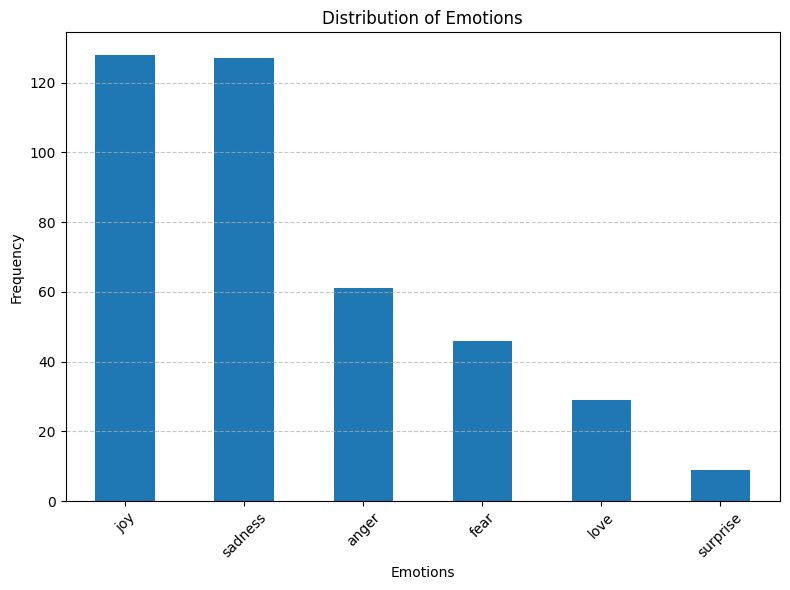

In [6]:
# Mapping of numeric labels to emotions
label_mapping = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
}

# Count occurrences of each emotion
label_counts = df['label'].map(label_mapping).value_counts()

# Plotting
plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar')
plt.title('Distribution of Emotions')
plt.xlabel('Emotions')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if needed
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [10]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [11]:
port_stem = PorterStemmer()

In [12]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# Function for stemming and tokenizing
def clean_text(text):
    stemmed_content = re.sub('[^a-zA-Z]', ' ', text)
    stemmed_content = stemmed_content.lower()
    tokens = word_tokenize(stemmed_content)
    stemmed_tokens = [port_stem.stem(word) for word in tokens if not word in stopwords.words('english')]
    cleaned_text = ' '.join(stemmed_tokens)
    return cleaned_text

# Apply the clean_text function to the 'text' column in your DataFrame
df['text'] = df['text'].apply(clean_text)

# Print the DataFrame to see the results
print(df['text'])


0                       feel realli helpless heavi heart
1      ive enjoy abl slouch relax unwind frankli need...
2                   gave internship dmrg feel distraught
3                                    dont know feel lost
4      kindergarten teacher thoroughli weari job take...
                             ...                        
395                                   feel naughti today
396    love read book best educ kid part care strongl...
397    hurt actual thought need anyon els help made f...
398                                 feel angri asham sad
399       feel urg yell greedi teabag lick potato bottom
Name: text, Length: 400, dtype: object


# ***CBOW***

In [13]:
emo = df['text']

In [16]:
# Preprocess the dataset
words = " ".join(emo).split()
vocab = list(set(words))
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
idx_to_word = {idx: word for word, idx in word_to_idx.items()}
V = len(vocab)
context_window = 3 # take 3 words before and after the target
word_vectors = np.random.uniform(0, 1, (V, 100))

In [17]:
# Function to generate context-target pairs
def generate_cbow_data(emo, context_window, word_to_idx):
    data = []
    for sentence in emo:
        sentence = sentence.split()
        for target_word_idx, target_word in enumerate(sentence):
            for context_word_idx in range(
                max(0, target_word_idx - context_window),
                min(len(sentence), target_word_idx + context_window + 1),
            ):
                if context_word_idx != target_word_idx:
                    context_word = sentence[context_word_idx]
                    target = word_to_idx[target_word]
                    context = word_to_idx[context_word]
                    data.append((context, target))
    return data

In [18]:
data = generate_cbow_data(emo, context_window, word_to_idx)
print(data)
print( word_to_idx)

for context, target in data:
    print(f"Context: {idx_to_word[context]}, Target: {idx_to_word[target]}")

Streaming output truncated to the last 5000 lines.
Context: feel, Target: time
Context: word, Target: time
Context: anger, Target: time
Context: asnt, Target: time
Context: fault, Target: time
Context: word, Target: asnt
Context: anger, Target: asnt
Context: time, Target: asnt
Context: fault, Target: asnt
Context: anger, Target: fault
Context: time, Target: fault
Context: asnt, Target: fault
Context: someon, Target: feel
Context: hand, Target: feel
Context: wrap, Target: feel
Context: feel, Target: someon
Context: hand, Target: someon
Context: wrap, Target: someon
Context: around, Target: someon
Context: feel, Target: hand
Context: someon, Target: hand
Context: wrap, Target: hand
Context: around, Target: hand
Context: frighten, Target: hand
Context: feel, Target: wrap
Context: someon, Target: wrap
Context: hand, Target: wrap
Context: around, Target: wrap
Context: frighten, Target: wrap
Context: think, Target: wrap
Context: someon, Target: around
Context: hand, Target: around
Context: w

In [19]:
# Training CBOW model
learning_rate = 0.01
epochs = 10

for epoch in range(epochs):
    total_loss = 0
    data = generate_cbow_data(emo, context_window, word_to_idx)
    for context, target in data:
        context_vector = word_vectors[context]
        predicted = np.dot(context_vector, word_vectors.T)
        y = np.zeros(V)
        y[target] = 1
        error = y - predicted
        total_loss += np.sum(error ** 2)
        for j in range(V):
            word_vectors[j] += learning_rate * error[j] * context_vector

    if (epoch + 1) % 1 == 0:
        print(f"Epoch {epoch + 1}, Loss: {total_loss}")

Epoch 1, Loss: 2908957.8037178493
Epoch 2, Loss: 29134.768256218278
Epoch 3, Loss: 21987.543933028282
Epoch 4, Loss: 20129.793542064006
Epoch 5, Loss: 19371.776141706265
Epoch 6, Loss: 18986.66835982383
Epoch 7, Loss: 18763.02239937213
Epoch 8, Loss: 18620.68945894508
Epoch 9, Loss: 18523.803827291067
Epoch 10, Loss: 18454.355016732894


In [20]:
print(word_vectors.shape)
word_vectors

(1406, 100)


array([[-0.00114917,  0.02197998, -0.00123788, ..., -0.01856321,
        -0.02095277,  0.02965989],
       [ 0.01205361,  0.00176733,  0.00952865, ...,  0.02776604,
        -0.02063323, -0.01673596],
       [-0.01621482,  0.00935601,  0.00144708, ...,  0.01312285,
         0.00707734,  0.01781178],
       ...,
       [ 0.01658052,  0.0024088 ,  0.02954572, ..., -0.00345834,
         0.00861374, -0.00891701],
       [ 0.02841397, -0.00680853,  0.01339993, ...,  0.00040065,
         0.03460676, -0.01108782],
       [-0.00470714, -0.01361973, -0.00150283, ..., -0.00689321,
        -0.03592822, -0.01793975]])

# **SKIP**-**GRAM**

In [21]:
skipemo = df['text']

In [22]:
# Preprocess the dataset
words = " ".join(skipemo).split()
vocab = list(set(words))
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
idx_to_word = {idx: word for word, idx in word_to_idx.items()}
V = len(vocab)
context_window = 3 # take 3 words before and after the target
word_vectors1 = np.random.uniform(-1, 1, (V, 100))
context_vectors = np.random.uniform(-1, 1, (V, 100))  # Additional context vectors for Skip-gram


In [23]:
# Function to generate target-context pairs for Skip-gram
def generate_skipgram_data(skipemo, context_window, word_to_idx):
    data = []
    for sentence in emo:
        sentence = sentence.split()
        for target_word_idx, target_word in enumerate(sentence):
            for context_word_idx in range(
                max(0, target_word_idx - context_window),
                min(len(sentence), target_word_idx + context_window + 1),
            ):
                if context_word_idx != target_word_idx:
                    context_word = sentence[context_word_idx]
                    target = word_to_idx[target_word]
                    context = word_to_idx[context_word]
                    data.append((target, context))
    return data


In [24]:
data = generate_skipgram_data(skipemo, context_window, word_to_idx)
print(data)

# Print generated data
for target, context in data:
    print(f"Target: {idx_to_word[target]}, Context: {idx_to_word[context]}")


Streaming output truncated to the last 5000 lines.
Target: need, Context: stop
Target: stop, Context: need
Target: stop, Context: bring
Target: bring, Context: stop
Target: bring, Context: breath
Target: breath, Context: bring
Target: breath, Context: back
Target: back, Context: breath
Target: back, Context: calm
Target: calm, Context: back
Target: calm, Context: zen
Target: zen, Context: calm
Target: zen, Context: like
Target: like, Context: zen
Target: like, Context: seren
Target: seren, Context: like
Target: feel, Context: triumphant
Target: triumphant, Context: feel
Target: triumphant, Context: reason
Target: reason, Context: triumphant
Target: feel, Context: look
Target: look, Context: feel
Target: look, Context: like
Target: like, Context: look
Target: like, Context: one
Target: one, Context: like
Target: one, Context: mayb
Target: mayb, Context: one
Target: mayb, Context: still
Target: still, Context: mayb
Target: still, Context: singl
Target: singl, Context: still
Target: singl

In [25]:
# Training Skip-gram model
learning_rate = 0.001
epochs = 40  # we increased number of epochs because skip-gram executes faster

for epoch in range(epochs):
    total_loss = 0
    for target, context in data:
        target_vector = word_vectors1[target]
        context_vector = context_vectors[context]
        predicted = np.dot(target_vector, context_vectors.T)
        y = np.zeros(V)
        y[context] = 1
        error = y - predicted
        total_loss += np.sum(error ** 2)
        word_vectors1[target] += learning_rate * np.dot(error, context_vectors)
        context_vectors += learning_rate * np.outer(error, target_vector)

    if (epoch + 1) % 1 == 0:
        print(f"Epoch {epoch + 1}, Loss: {total_loss}")


Epoch 1, Loss: 21789281.60583911
Epoch 2, Loss: 1860480.7269505574
Epoch 3, Loss: 686880.4941067493
Epoch 4, Loss: 337896.9051365041
Epoch 5, Loss: 194007.7351040824
Epoch 6, Loss: 123340.24675513257
Epoch 7, Loss: 84463.0713819905
Epoch 8, Loss: 61269.15686052123
Epoch 9, Loss: 46555.56270650004
Epoch 10, Loss: 36759.07092400726
Epoch 11, Loss: 29975.768735869875
Epoch 12, Loss: 25124.119557627753
Epoch 13, Loss: 21558.194443270324
Epoch 14, Loss: 18875.721049881908
Epoch 15, Loss: 16817.080694196826
Epoch 16, Loss: 15209.49015638623
Epoch 17, Loss: 13934.835457851981
Epoch 18, Loss: 12910.450668725376
Epoch 19, Loss: 12077.260766460024
Epoch 20, Loss: 11392.25817386028
Epoch 21, Loss: 10823.607496303697
Epoch 22, Loss: 10347.38761376897
Epoch 23, Loss: 9945.378847725173
Epoch 24, Loss: 9603.531956888075
Epoch 25, Loss: 9310.890930359368
Epoch 26, Loss: 9058.823355157663
Epoch 27, Loss: 8840.462753115868
Epoch 28, Loss: 8650.299251807914
Epoch 29, Loss: 8483.875531528354
Epoch 30, Los

In [26]:
print(word_vectors1.shape)
word_vectors1

(1406, 100)


array([[ 3.34813098e-01,  7.60181635e-02,  1.92087138e-02, ...,
        -2.26594232e-01, -6.82577350e-02,  2.95474493e-01],
       [ 3.85592930e-02,  4.45559867e-02, -2.29403398e-02, ...,
        -1.95751672e-01, -1.44364743e-01, -8.62795568e-02],
       [ 1.68242908e-01, -3.47231281e-01,  3.28394516e-04, ...,
         2.81273588e-01, -2.77884499e-01,  1.81741293e-01],
       ...,
       [-1.32341696e-02,  3.96205560e-01,  1.66756687e-02, ...,
        -1.40786557e-01, -7.00027759e-02,  4.26836322e-02],
       [ 6.52049879e-02,  2.28089653e-02,  2.28787593e-02, ...,
        -1.12698924e-01,  5.40607951e-02,  3.13274309e-02],
       [-2.48180586e-01, -1.56490308e-01,  2.43772351e-02, ...,
         2.36188141e-01,  1.44215162e-01,  1.83315670e-01]])

# **(WORD2VEC)**








# **CBOW using** **WORD2VEC**
# **Applying Machine learning classfier (Logistic Regression)**
 **We applying the models on the whole dataset because it was too much faster than cbow and skip-gram from scratch to execute**

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from gensim.models import Word2Vec

df = pd.read_csv("text.csv")

# Define stopwords
stop_words = set(stopwords.words('english'))


# Function to preprocess text
# we didnot use the previous function (clean_text) we created before because it takes too long to execute on the whole dataset
# Function to preprocess text (tokinize, stemming, remove non alphabtic characters)
def preprocess_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens]
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [port_stem.stem(word) for word in tokens]
    return tokens

# Apply the function on text column
df['tokenized_text'] = df['text'].apply(preprocess_text)

# Train the CBOW model
sentences = df['tokenized_text'].tolist()
cbow_model = Word2Vec(sentences=sentences, vector_size=100, window=5, min_count=1, sg=0)

# Function to convert text data to fixed-size word vectors using the CBOW model
def text_to_vectors(text):
    vectors = []
    for word in text:
        if word in cbow_model.wv:
            vectors.append(cbow_model.wv[word])
    return np.mean(vectors, axis=0) if vectors else np.zeros(cbow_model.vector_size)

# Convert text data into word vectors
X = df['tokenized_text'].apply(text_to_vectors)
X = np.vstack(X)
y = df['label']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a logistic regression classifier
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Evaluate the accuracy
accuracy = classifier.score(X_test, y_test)
print("Accuracy:", accuracy)


Accuracy: 0.6813776061035004


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion Matrix of CBOW using Logistic Regression classifier


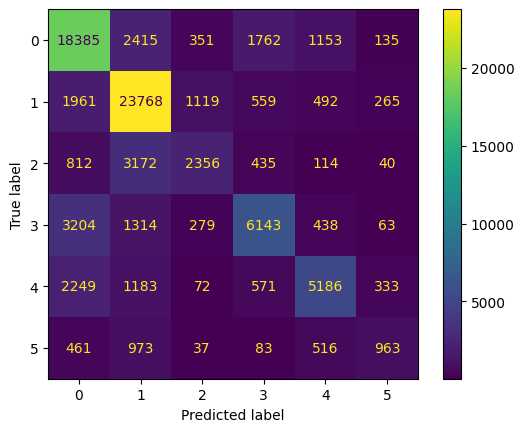

Accuracy on training set for CBOW: 0.683
Accuracy on testing set for CBOW: 0.681


In [59]:
# A Confusion matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
print("Confusion Matrix of CBOW using Logistic Regression classifier")
y_pred = classifier.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)
cm=ConfusionMatrixDisplay(confusion)
cm.plot()
plt.show()

# Represent the accuracy on training/testing set

print("Accuracy on training set for CBOW: {:.3f}".format(classifier.score(X_train, y_train)))
print("Accuracy on testing set for CBOW: {:.3f}".format(classifier.score(X_test, y_test)))

# Skip-gram using **WORD2VEC**

In [61]:
df = pd.read_csv("text.csv")

stop_words = set(stopwords.words('english'))

# Function to preprocess text (tokinize, stemming, remove non alphabtic characters)
def preprocess_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text)  # Remove non-alphabetic characters
    tokens = word_tokenize(text)  # Tokenize the text
    tokens = [word.lower() for word in tokens]  # Convert tokens to lowercase
    tokens = [word for word in tokens if word not in stop_words]  # Remove stop words
    tokens = [port_stem.stem(word) for word in tokens]  # Stemming
    return tokens

# Apply the function on text column
df['tokenized_text'] = df['text'].apply(preprocess_text)

# Train the Skip-gram model
sentences = df['tokenized_text'].tolist()
skip_model = Word2Vec(sentences=sentences, vector_size=100, window=5, min_count=1, sg=1)

# Function to convert text data to fixed-size word vectors using the CBOW model
def text_to_vectors(text):
    vectors = []
    for word in text:
        if word in skip_model.wv:
            vectors.append(skip_model.wv[word])
    return np.mean(vectors, axis=0) if vectors else np.zeros(skip_model.vector_size)

# Convert text data into word vectors
X = df['tokenized_text'].apply(text_to_vectors)
X = np.vstack(X)
y = df['label']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a logistic regression
classifier2 = LogisticRegression()
classifier2.fit(X_train, y_train)

# Evaluate the accuracy
accuracy = classifier2.score(X_test, y_test)
print("Accuracy:", accuracy)


Accuracy: 0.689774717497181


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion Matrix of Skip-gram(word2vec) using Logistic regression classifier


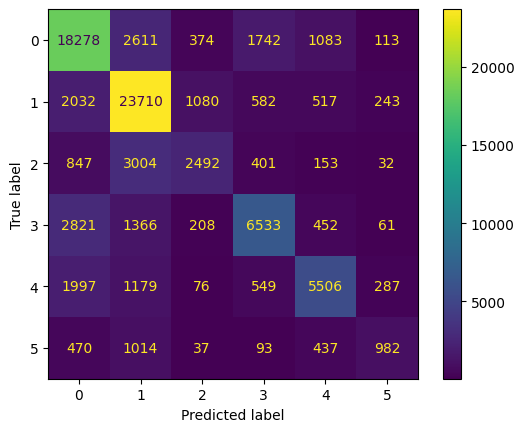

Accuracy on training set for skip-gram: 0.689
Accuracy on testing set for skip-gram: 0.690


In [62]:
# A Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
print("Confusion Matrix of Skip-gram(word2vec) using Logistic regression classifier")
y_pred_S = classifier2.predict(X_test)
confusions = confusion_matrix(y_test, y_pred_S)
cm=ConfusionMatrixDisplay(confusions)
cm.plot()
plt.show()

# Represent the accuracy on training/testing set

print("Accuracy on training set for skip-gram: {:.3f}".format(classifier2.score(X_train, y_train)))
print("Accuracy on testing set for skip-gram: {:.3f}".format(classifier2.score(X_test, y_test)))

# **Both CBOW(word2vec) and skip-gram(word2vec) models perform comparably well, with slightly better performance on the testing set for the skip-gram model.**
